In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
filename = 'bank-additional-full.csv'

In [3]:
#https://archive.ics.uci.edu/ml/datasets/bank+marketing
#[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

#Don't think too much about the getDataset method. It is used for convenience
def getDataset(filename, **kwargs):
    url = f'https://github.com/IvanReznikov/mdx-msc-data-science/raw/main/datasets/{filename}'
    try:
        import os
        if filename not in os.listdir():
            !pip install wget
            import wget
            downloaded_filename = wget.download(url)
            print(f'{downloaded_filename} file downloaded')
        else:
            print(f'{filename} already exists')
        return pd.read_csv(filename, **kwargs)
        
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

In [4]:
data = getDataset(filename,sep=';') # note that the delimiter for this dataset is ";"
data = data.drop('duration',axis=1) # as recommended by the dataset description, we will drop the last contact duration values.
data.head()

bank-additional-full.csv already exists


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

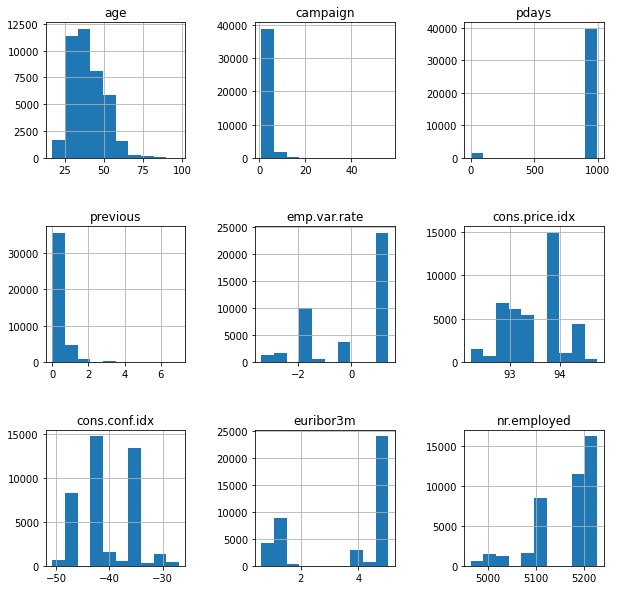

In [6]:
header = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
data.hist(column=header,figsize=(10,10))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

### Categorical variables handling

#### Ordinal variables

In [7]:
data['poutcome'] = data['poutcome'].map({'failure': -1,'nonexistent': 0,'success': 1})
data['default'] = data['default'].map({'yes': -1,'unknown': 0,'no': 1})
data['housing'] = data['housing'].map({'yes': -1,'unknown': 0,'no': 1})
data['loan'] = data['loan'].map({'yes': -1,'unknown': 0,'no': 1})

*How would you consider treating "education"? How ould you compare "professional.course" to other categories? Shall we consider it as a ordinal or nominal variable?*

#### Nominal variables
All other categorical variables except "poutcome", "default", "housing" and "loan" are considered nominal. We will use **one-hot encoding** on these variables. For example, we have marital = ['divorced', 'married', 'single', 'unknown']. The one-hot representation for each of the categories will be:
<center>
    $divorced = [1,0,0,0]$ <br/>
    $married = [0,1,0,0]$<br/>
    $single = [0,0,1,0]$<br/>
   $unknown = [0,0,0,1]$<br/>
</center>

In [8]:
nominal = ['job','marital','education','contact','month','day_of_week']
dataProcessed = pd.get_dummies(data,columns=nominal)

#### Binary varaibles

In [9]:
dataProcessed['y']=dataProcessed['y'].map({'yes': 1,'no': 0})
dataProcessed.head()

,age,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,1,1,1,1,999,0,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,0
1,57,0,1,1,1,999,0,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,0
2,37,1,-1,1,1,999,0,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,0
3,40,1,1,1,1,999,0,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,0
4,56,1,1,-1,1,999,0,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,0


## Train, test split and model selection

In [10]:
#if the training is running too long, try finding params on lower amount of data
dataProcessed = dataProcessed.loc[:int(dataProcessed.shape[0]//20)]

In [11]:
from sklearn.model_selection import train_test_split

# raw data
X = dataProcessed.drop('y', axis=1).values
y = dataProcessed['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X train size:  (1545, 54)
y train size:  (1545,)
X test size:  (515, 54)
y test size:  (515,)


Before the training starts, standardize the *numeric* variables in the training set:

In [12]:
idx_numeric_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
idx_numeric = [dataProcessed.columns.get_loc(x) for x in idx_numeric_cols]

In [13]:
# standardize numeric variables only
scaler = StandardScaler()
X_train[:,idx_numeric]=scaler.fit_transform(X_train[:,idx_numeric])
X_test[:,idx_numeric]=scaler.transform(X_test[:,idx_numeric])

In [14]:
from sklearn.model_selection import GridSearchCV

clf = SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1], 'C': [0.1, 1, 10, 100]}, 
              {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}]
grid = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, scoring='precision', verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'kernel': ['linear']}],
             scoring='precision', verbose=1)

In [15]:
print('The best model is: ', grid.best_params_)

The best model is:  {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


## Final performance
Now that we have the best model, let's see how it performs on the evaluation set $(X_{test}, y_{test})$:

In [16]:
from sklearn.metrics import precision_score, accuracy_score

In [17]:
y_true, y_pred = y_test, grid.predict(X_test)
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

accuracy on the evaluation set:  0.9825242718446602


/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning

/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning

/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ivan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning